# Sam2 Matting - Дообучение

## Импорты

In [1]:
import torch
from torch import nn, Tensor
import torchvision
import os
import tarfile
import shutil
import sys
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from torch.optim import AdamW
from typing import List
import torch.nn.functional as F
import logging
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

Подключаем гугл-диск (если работаете в colab)

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Подготовка VideoMatte240K

Разархивируем архив с видео датасета VideoMatte240K. Предполагается, что архив находится на диске.

In [3]:
# Путь к архиву
archive_path = '/content/drive/MyDrive/Matting Project/VideoMatte240K_JPEG_SD.tar'

# Папка, куда мы разархивируем данные
extract_path = '/content/VideoMatte240K'

# Разархивируем файл
with tarfile.open(archive_path, "r") as tar:
    tar.extractall(path=extract_path)

print(f"Архив разархивирован в {extract_path}")


Архив разархивирован в /content/VideoMatte240K


Так как в папке test у нас только 4 видео, мы их использовать не будем. В место этого в качестве train используем первые 100 видео папки train. В качестве test используем видеко 100-200 - поместим их в папку train_test.

В каждом видео в целях оптимизации оставим не больше 40 кадров. Некоторые видео удалим, так как они включают в себя пустые маски и некорректно обрабатываются.

In [ ]:
# Путь к папкам fgr и pha
base_path = "/content/VideoMatte240K/VideoMatte240K_JPEG_SD/train"
folders = ["fgr", "pha"]

# Папка для сохранения train_test
train_test_path = os.path.join(base_path, "train_test")
os.makedirs(train_test_path, exist_ok=True)

# Максимальное количество папок и изображений
max_folders = 100
max_images = 40
delete_specific_folder = 79
delete_specific_folder2 = 124

for folder in folders:
    folder_path = os.path.join(base_path, folder)

    # Сортируем папки по имени
    subfolders = sorted(os.listdir(folder_path))

    for i, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(folder_path, subfolder)
        if 100 <= i < 200:
            if i == delete_specific_folder2:
              shutil.rmtree(subfolder_path)
            else:
              # Перемещаем папки 100-199 в train_test
              new_subfolder_path = os.path.join(train_test_path, folder, subfolder)
              os.makedirs(os.path.dirname(new_subfolder_path), exist_ok=True)
              shutil.move(subfolder_path, new_subfolder_path)

              # Оставляем в них не более max_images изображений
              images = sorted(os.listdir(new_subfolder_path))
              for img_idx, img_name in enumerate(images):
                  img_path = os.path.join(new_subfolder_path, img_name)
                  if img_idx >= max_images:
                      os.remove(img_path)

        elif i >= max_folders or i == delete_specific_folder:
            # Удаляем лишние папки
            shutil.rmtree(subfolder_path)

        else:
            # Обрабатываем оставшиеся папки
            images = sorted(os.listdir(subfolder_path))
            for img_idx, img_name in enumerate(images):
                img_path = os.path.join(subfolder_path, img_name)
                if img_idx >= max_images:
                    os.remove(img_path)

print("Обработка завершена.")


Обработка завершена.


Разделим видео на части по 20 изображений в каждом, чтобы они попали в разные батчи.

In [ ]:
def separate_folders(base_path):
  folders = ["fgr", "pha"]

  # Количество изображений в каждой новой папке
  images_per_subfolder = 20

  for folder in folders:
      folder_path = os.path.join(base_path, folder)

      # Получаем список подпапок
      subfolders = sorted(os.listdir(folder_path))

      for subfolder in subfolders:
          subfolder_path = os.path.join(folder_path, subfolder)

          # Получаем список изображений
          images = sorted(os.listdir(subfolder_path))
          total_images = len(images)

          # Разделяем изображения на группы по images_per_subfolder
          for idx, img_name in enumerate(images):
              group_index = idx // images_per_subfolder + 1
              new_subfolder_name = f"{subfolder}_part{group_index}"
              new_subfolder_path = os.path.join(folder_path, new_subfolder_name)

              # Создаем новую подпапку, если она еще не создана
              if not os.path.exists(new_subfolder_path):
                  os.makedirs(new_subfolder_path)

              # Перемещаем изображение в соответствующую подпапку
              old_img_path = os.path.join(subfolder_path, img_name)
              new_img_path = os.path.join(new_subfolder_path, img_name)
              os.rename(old_img_path, new_img_path)

          # Удаляем пустую исходную подпапку
          os.rmdir(subfolder_path)

  print("Разделение папок завершено.")

In [ ]:
separate_folders("/content/VideoMatte240K/VideoMatte240K_JPEG_SD/train")
separate_folders("/content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/train_test")

Разделение папок завершено.
Разделение папок завершено.


Сохраняем пути папок

In [ ]:
extract_path = '/content/VideoMatte240K'
mid_dir = os.path.join(extract_path, 'VideoMatte240K_JPEG_SD')
# Папки train и test после разархивирования
train_dir = os.path.join(mid_dir, 'train')
test_dir = os.path.join(mid_dir, 'train/train_test')

# Папки fgr и pha
fgr_dir = os.path.join(train_dir, 'fgr')  # или test_dir, если используем для тестирования
pha_dir = os.path.join(train_dir, 'pha')

fgr_dir_test = os.path.join(test_dir, 'fgr')  # или test_dir, если используем для тестирования
pha_dir_test = os.path.join(test_dir, 'pha')


## Натройка среды

In [ ]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True


Подключаем модули с sam2 и доустанавливаем необходимые зависимости.

Необходимо, чтобы файлы с модулями лежали на googe drive. В качестве альтернативы можно установить sam2 по инструкции от meta.

In [ ]:
sys.path.append('/content/drive/My Drive/Matting Project/sam2')

In [ ]:
!{sys.executable} -m pip install tensordict > /dev/null

In [ ]:
!{sys.executable} -m pip install hydra-core > /dev/null

In [ ]:
!{sys.executable} -m pip install iopath > /dev/null

In [ ]:
!pip install torchinfo > /dev/null

Импортируем необходимые при работе с датасетом и обучении модели модули

In [ ]:
from hydra import initialize_config_dir, compose
from hydra.core.global_hydra import GlobalHydra
from hydra.utils import instantiate
from omegaconf import OmegaConf
from training.dataset.sam2_datasets import TorchTrainMixedDataset
from training.dataset.utils import RepeatFactorWrapper, ConcatDataset
from training.dataset.vos_dataset import VOSDataset
from training.dataset.vos_raw_dataset import PNGRawDataset
from training.dataset.vos_sampler import RandomUniformSampler
from training.utils.data_utils import Frame, Object, VideoDatapoint, collate_fn, BatchedVideoDatapoint, BatchedVideoMetaData
from training.dataset.transforms import ComposeAPI, RandomAffine, RandomResizeAPI, ToTensorAPI, NormalizeAPI
from training.dataset.transforms import ColorJitter, RandomHorizontalFlip, RandomGrayscale
from sam2.sam2_video_predictor import SAM2VideoPredictor

## Dataloaders

Создаем класс для работы с датасетом, список трансформаций и функцию для упаковки изображений датасета в класс BatchedVideoDatapoint, который ожидает модель для обучения

In [ ]:
class VideoMatteDataset(Dataset):
    def __init__(self, fgr_dir: str, pha_dir: str, transform=None):
        """
        Args:
            fgr_dir (str): Путь к директории с foreground изображениями.
            pha_dir (str): Путь к директории с масками (alpha matte).
            transform: Трансформация, применяемая к изображениям и маскам.
        """
        self.fgr_dir = fgr_dir
        self.pha_dir = pha_dir
        self.transform = transform

        # Сопоставление видео и файлов
        self.video_ids = sorted(os.listdir(fgr_dir))

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, index):
        video_id = self.video_ids[index]

        # Получаем пути к изображению и маскам
        fgr_video_dir = os.path.join(self.fgr_dir, video_id)
        pha_video_dir = os.path.join(self.pha_dir, video_id)

        fgr_frames = sorted(os.listdir(fgr_video_dir))
        pha_frames = sorted(os.listdir(pha_video_dir))

        # Считываем все кадры из видео
        frames = []
        for fgr_frame, pha_frame in zip(fgr_frames, pha_frames):
            fgr_path = os.path.join(fgr_video_dir, fgr_frame)
            pha_path = os.path.join(pha_video_dir, pha_frame)

            fgr_image = Image.open(fgr_path).convert("RGB")
            pha_image = Image.open(pha_path).convert("L")  # Маска в grayscale

            pha_image = T.ToTensor()(pha_image)

            w, h = fgr_image.size

            # Создаем объект Frame
            frame = Frame(
                data=fgr_image,
                objects=[
                    Object(
                        object_id=0,
                        frame_index=int(fgr_frame.split(".")[0]),  # Пример: "000.png" -> 0
                        segment=pha_image,
                    )
                ],
            )

            frames.append(frame)

        # Создаем VideoDatapoint
        video = VideoDatapoint(
            frames=frames,
            video_id=index,
            size = (h, w)
        )

        if self.transform:
                video = self.transform(video)

        return video

In [ ]:
train_transforms = ComposeAPI(
    transforms=[
        RandomAffine(degrees=25, shear=20, image_interpolation="bilinear", consistent_transform=True),
        RandomResizeAPI(sizes=[256], square=True, consistent_transform=True),
        ColorJitter(brightness=0.1, contrast=0.03, saturation=0.03, consistent_transform=True, hue=None),
        RandomGrayscale(p=0.05, consistent_transform=True),
        ColorJitter(brightness=0.1, contrast=0.05, saturation=0.05, consistent_transform=False, hue =None),
        ToTensorAPI(),
        NormalizeAPI(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
def my_collate_fn(
    batch: List[VideoDatapoint],
    dict_key,
) -> BatchedVideoDatapoint:
    """
    Args:
        batch: A list of VideoDatapoint instances.
        dict_key (str): A string key used to identify the batch.
    """
    img_batch = []
    for video in batch:
        img_batch += [torch.stack([frame.data for frame in video.frames], dim=0)]

    img_batch = torch.stack(img_batch, dim=0).permute((1, 0, 2, 3, 4))
    T = img_batch.shape[0]
    # Prepare data structures for sequential processing. Per-frame processing but batched across videos.
    step_t_objects_identifier = [[] for _ in range(T)]
    step_t_frame_orig_size = [[] for _ in range(T)]

    step_t_masks = [[] for _ in range(T)]
    step_t_obj_to_frame_idx = [
        [] for _ in range(T)
    ]  # List to store frame indices for each time step

    for video_idx, video in enumerate(batch):
        orig_video_id = video.video_id
        orig_frame_size = video.size
        for t, frame in enumerate(video.frames):
            objects = frame.objects
            for obj in objects:
                orig_obj_id = obj.object_id
                orig_frame_idx = obj.frame_index
                step_t_obj_to_frame_idx[t].append(
                    torch.tensor([t, video_idx], dtype=torch.int)
                )
                step_t_masks[t].append(obj.segment)
                step_t_objects_identifier[t].append(
                    torch.tensor([orig_video_id, orig_obj_id, orig_frame_idx])
                )
                step_t_frame_orig_size[t].append(torch.tensor(orig_frame_size))

    obj_to_frame_idx = torch.stack(
        [
            torch.stack(obj_to_frame_idx, dim=0)
            for obj_to_frame_idx in step_t_obj_to_frame_idx
        ],
        dim=0,
    )
    masks = torch.stack([torch.stack(masks, dim=0) for masks in step_t_masks], dim=0)
    objects_identifier = torch.stack(
        [torch.stack(id, dim=0) for id in step_t_objects_identifier], dim=0
    )
    frame_orig_size = torch.stack(
        [torch.stack(id, dim=0) for id in step_t_frame_orig_size], dim=0
    )
    return BatchedVideoDatapoint(
        img_batch=img_batch,
        obj_to_frame_idx=obj_to_frame_idx,
        masks=masks,
        metadata=BatchedVideoMetaData(
            unique_objects_identifier=objects_identifier,
            frame_orig_size=frame_orig_size,
        ),
        dict_key=dict_key,
        batch_size=[T],
    )

Создает лоудеры для train и test данных

In [ ]:
# Создание датасета
dataset = VideoMatteDataset(fgr_dir=fgr_dir, pha_dir=pha_dir, transform=train_transforms)

# Создание DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=1,  # Подаем по одному видео
    shuffle=True,
    collate_fn=lambda batch: my_collate_fn(batch, dict_key="VideoMatteBatch"),
)

In [ ]:
# Создание датасета
test_dataset = VideoMatteDataset(fgr_dir=fgr_dir_test, pha_dir=pha_dir_test, transform=train_transforms)

# Создание DataLoader
testdataloader = DataLoader(
    test_dataset,
    batch_size=1,  # Подаем по одному видео
    shuffle=False,
    collate_fn=lambda batch: my_collate_fn(batch, dict_key="VideoMatteBatch"),
)

Проверяем, что загрузка данных работает корректно

In [ ]:
for batched_data in dataloader:
    example = batched_data
    print("Images batch shape:", batched_data.img_batch.shape)
    print("Masks shape:", batched_data.masks.shape)
    print("Metadata:", batched_data.metadata)
    break

Images batch shape: torch.Size([20, 1, 3, 256, 256])
Masks shape: torch.Size([20, 1, 256, 256])
Metadata: BatchedVideoMetaData(
    frame_orig_size=Tensor(shape=torch.Size([20, 1, 2]), device=cpu, dtype=torch.int64, is_shared=False),
    unique_objects_identifier=Tensor(shape=torch.Size([20, 1, 3]), device=cpu, dtype=torch.int64, is_shared=False),
    batch_size=torch.Size([20]),
    device=None,
    is_shared=False)


## Конфигурация модели

Загружаем конфигурацию модели для обучения с помощью hydra и OmegaConf. Ее создали самостоятельно на основании имеющихся

In [ ]:
config_dir = "/content/drive/My Drive/Matting Project/configs"
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize_config_dir(config_dir=config_dir, version_base="1.1")
cfg = compose(config_name="sam2.1_hiera_l_training.yaml")

Инициализируем модель

In [ ]:
model = instantiate(cfg["model"])

Создаем класс lora-адаптера, а также классы MLPWithLoRA, AttentionWithLoRA, которыми мы заменим классы оригинальной модели

In [ ]:
class LoRALayer(nn.Module):
    def __init__(self, in_features, out_features, rank=4, init_std=1e-3):
        super(LoRALayer, self).__init__()
        self.low_rank_down = nn.Linear(in_features, rank, bias=False)
        self.low_rank_up = nn.Linear(rank, out_features, bias=False)

        # Инициализация весов LoRA для нулевого выхода
        self.reset_parameters(init_std)

    def reset_parameters(self, init_std):
        # Инициализируем веса так, чтобы результат был равен нулю
        nn.init.normal_(self.low_rank_down.weight, mean=0.0, std=init_std)
        nn.init.normal_(self.low_rank_up.weight, mean=0.0, std=init_std)

    def forward(self, x):
        return self.low_rank_up(self.low_rank_down(x))

class LoRALinearLayer(nn.Module):
    def __init__(self, in_features, out_features, rank=4):
        super(LoRALinearLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.lora_adapter = LoRALayer(in_features, out_features, rank)

    def forward(self, x):
        # Сначала обычный линейный слой, затем LoRA адаптер
        return self.linear(x) + self.lora_adapter(x)

class MLPWithLoRA(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        activation: nn.Module = nn.ReLU,
        sigmoid_output: bool = False,
        rank: int = 32
    ) -> None:
        super(MLPWithLoRA, self).__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)

        # Используем LoRALinearLayer вместо обычных nn.Linear
        self.layers = nn.ModuleList(
            LoRALinearLayer(n, k, rank) for n, k in zip([input_dim] + h, h + [output_dim])
        )

        self.sigmoid_output = sigmoid_output
        self.act = activation()

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = self.act(layer(x)) if i < self.num_layers - 1 else layer(x)

        if self.sigmoid_output:
            x = torch.sigmoid(x)

        return x

class AttentionWithLoRA(nn.Module):
    """
    An attention layer with optional LoRA adapters for the linear projections.
    """
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        downsample_rate: int = 1,
        dropout: float = 0.0,
        kv_in_dim: int = None,
        rank: int = 8,  # Rank for LoRA adapters
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.kv_in_dim = kv_in_dim if kv_in_dim is not None else embedding_dim
        self.internal_dim = embedding_dim // downsample_rate
        self.num_heads = num_heads
        assert (
            self.internal_dim % num_heads == 0
        ), "num_heads must divide embedding_dim."

        # Initialize linear layers with optional LoRA adapters
        self.q_proj = LoRALinearLayer(embedding_dim, self.internal_dim, rank)
        self.k_proj = LoRALinearLayer(self.kv_in_dim, self.internal_dim, rank)
        self.v_proj = LoRALinearLayer(self.kv_in_dim, self.internal_dim, rank)
        self.out_proj = LoRALinearLayer(self.internal_dim, embedding_dim, rank)

        self.dropout_p = dropout

    def _separate_heads(self, x: Tensor, num_heads: int) -> Tensor:
        b, n, c = x.shape
        x = x.reshape(b, n, num_heads, c // num_heads)
        return x.transpose(1, 2)  # B x N_heads x N_tokens x C_per_head

    def _recombine_heads(self, x: Tensor) -> Tensor:
        b, n_heads, n_tokens, c_per_head = x.shape
        x = x.transpose(1, 2)
        return x.reshape(b, n_tokens, n_heads * c_per_head)  # B x N_tokens x C

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        # Input projections
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Separate into heads
        q = self._separate_heads(q, self.num_heads)
        k = self._separate_heads(k, self.num_heads)
        v = self._separate_heads(v, self.num_heads)

        dropout_p = self.dropout_p if self.training else 0.0
        # Attention
        out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)

        out = self._recombine_heads(out)
        out = self.out_proj(out)

        return out

Заменяем классы на соответствующие с lora - адаптером

In [ ]:
transformer_dim = model.sam_mask_decoder.transformer_dim
num_mask_tokens = model.sam_mask_decoder.num_mask_tokens

model.sam_mask_decoder.output_hypernetworks_mlps = nn.ModuleList(
            [
                MLPWithLoRA(transformer_dim, transformer_dim, transformer_dim // 8, 3)
                for i in range(num_mask_tokens)
            ]
        )

In [ ]:
embedding_dim = model.sam_mask_decoder.transformer.embedding_dim
num_heads = model.sam_mask_decoder.transformer.num_heads
downsample_rate= 2

model.sam_mask_decoder.transformer.final_attn_token_to_image = AttentionWithLoRA(embedding_dim, num_heads, downsample_rate)

In [ ]:
print(model)

SAM2Train(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 144, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0-1): 2 x MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=144, out_features=432, bias=True)
            (proj): Linear(in_features=144, out_features=144, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((144,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=144, out_features=576, bias=True)
              (1): Linear(in_features=576, out_features=144, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (2): MultiScaleBlock(
          (norm1): LayerNorm((144,), eps=1e-06, elementwise_aff

## Чекпойнты

Загружаем чекпойнты оригинальной модели, заменяя назнания в соответствующих слоях

In [ ]:
def _load_checkpoint_lora(model, ckpt_path):
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu", weights_only=False)["model"]

        new_checkpoint = {}
        for key, value in sd.items():
            # Заменяем старое имя на новое для линейных слоев
            if 'output_hypernetworks_mlps' in key:
                # Переименовываем слои, добавляем 'linear' в нужные места
                new_key = key.replace('weight', 'linear.weight')
                new_key = new_key.replace('bias', 'linear.bias')
                new_checkpoint[new_key] = value
            elif 'final_attn_token_to_image' in key:
                # Переименовываем слои, добавляем 'linear' в нужные места
                new_key = key.replace('weight', 'linear.weight')
                new_key = new_key.replace('bias', 'linear.bias')
                new_checkpoint[new_key] = value
            else:
                # Для других слоев оставляем ключи без изменений
                new_checkpoint[key] = value

        missing_keys, unexpected_keys = model.load_state_dict(new_checkpoint, strict=False)
        logging.info("Loaded checkpoint sucessfully")

In [ ]:
_load_checkpoint_lora(model, "/content/drive/MyDrive/Matting Project/checkpoints/sam2.1_hiera_large.pt")

Обучать собираемся только параметры lora-слоев

In [ ]:
lora_params = [param for name, param in model.named_parameters() if "lora_adapter" in name]

for param in model.parameters():
      param.requires_grad = False

for param in lora_params:
      param.requires_grad = True

In [ ]:
batch_size = 16
from torchinfo import summary
summary(model, input = example)

Layer (type:depth-idx)                                  Param #
SAM2Train                                               1,280
├─ImageEncoder: 1-1                                     --
│    └─Hiera: 2-1                                       16,272
│    │    └─PatchEmbed: 3-1                             (21,312)
│    │    └─ModuleList: 3-2                             (212,111,712)
│    └─FpnNeck: 2-2                                     --
│    │    └─PositionEmbeddingSine: 3-3                  --
│    │    └─ModuleList: 3-4                             (553,984)
├─Conv2d: 1-2                                           (17)
├─MemoryAttention: 1-3                                  --
│    └─ModuleList: 2-3                                  --
│    │    └─MemoryAttentionLayer: 3-5                   (1,480,448)
│    │    └─MemoryAttentionLayer: 3-6                   (1,480,448)
│    │    └─MemoryAttentionLayer: 3-7                   (1,480,448)
│    │    └─MemoryAttentionLayer: 3-8             

Функции для сохранения и загрузки чекпойнтов по ходу обучения модели

In [ ]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Загружает чекпойнт модели и возвращает его данные.

    Parameters:
    - model: модель PyTorch
    - optimizer: оптимизатор
    - checkpoint_path: путь к сохраненному чекпойнту

    Returns:
    - epoch: эпоха, с которой продолжать обучение
    - losses: список тренировочных лоссов
    - test_losses: список тестовых лоссов
    """
    checkpoint = torch.load(checkpoint_path, map_location="cpu")

    # Загрузка состояния модели и оптимизатора
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])

    # Извлечение других данных
    epoch = checkpoint['epoch']
    losses = checkpoint['losses']
    test_losses = checkpoint['test_losses']

    print(f"Checkpoint loaded from {checkpoint_path}, starting from epoch {epoch + 1}")
    return epoch, losses, test_losses

In [ ]:
def save_checkpoint(model, optimizer, epoch, losses, test_losses, checkpoint_path):
    """
    Сохраняет чекпойнт модели.

    Parameters:
    - model: модель PyTorch
    - optimizer: оптимизатор
    - epoch: текущая эпоха
    - losses: список тренировочных лоссов
    - test_losses: список тестовых лоссов
    - checkpoint_path: путь для сохранения чекпойнта
    """
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'losses': losses,
        'test_losses': test_losses
    }
    torch.save(checkpoint, checkpoint_path)

## Обучение

L1 Loss и настройка параметров обучения

In [ ]:
def loss_matting(predictions, masks):
  loss = 0
  l1_loss = nn.L1Loss()
  for i in range(len(predictions)-1):
    pred = torch.sigmoid(predictions[i+1]["multistep_pred_multimasks_high_res"][0][0][0])
    mask = masks[i+1][0]
    loss += l1_loss(pred, mask)
  loss /= (len(predictions)-1)
  return loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_epochs =37
optimizer = AdamW(lora_params, lr=1e-5)

# Использование L1 Loss
loss_fn = loss_matting

In [ ]:
model = model.to(device)

Дообучаем модель

In [ ]:
checkpoint_path_latest = "/content/drive/MyDrive/Matting Project/checkpoints/latest_checkpoint.pth"
start_epoch = 0
losses = []
test_losses = []

if os.path.exists(checkpoint_path_latest):
    start_epoch, losses, test_losses = load_checkpoint(model, optimizer, checkpoint_path_latest)
    print(f"Resuming training from epoch {start_epoch + 1}")

for epoch in range(start_epoch, num_epochs):
    batch_num = 0
    loss_per_epoch = []
    model.train()
    train_progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batched_data in train_progress_bar:
        # Переносим данные на устройство (например, на GPU)
        batched_data = batched_data.to(device)
        gt_masks = batched_data.masks
        batched_data.masks = (batched_data.masks > 0.5)

        # Прогоняем данные через модель
        predictions = model(batched_data)

        # Вычисляем loss, оптимизируем и выполняем другие шаги обучения
        loss = loss_fn(predictions, gt_masks)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_num += 1
        loss_per_epoch.append(loss.item())
        train_progress_bar.set_postfix({"Loss": loss.item()})

    model.eval()
    test_loss_per_epoch = []
    test_progress_bar = tqdm(testdataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for batched_data in test_progress_bar:
          # Переносим данные на устройство (например, на GPU)
          batched_data = batched_data.to(device)
          gt_masks = batched_data.masks
          batched_data.masks = (batched_data.masks > 0.5)

          # Прогоняем данные через модель
          predictions = model(batched_data)

          # Вычисляем loss
          loss = loss_fn(predictions, gt_masks)
          test_loss_per_epoch.append(loss.item())
          test_progress_bar.set_postfix({"Test Loss": loss.item()})


    losses.append(np.mean(loss_per_epoch))
    test_losses.append(np.mean(test_loss_per_epoch))
    save_checkpoint(
        model, optimizer, epoch + 1, losses, test_losses, checkpoint_path_latest
    )
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses[-1]}, EvalLoss: {test_losses[-1]}")

torch.cuda.empty_cache()
gc.collect()

<ipython-input-31-22a5ddb48a4d>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu")


Checkpoint loaded from /content/drive/MyDrive/Matting Project/checkpoints/latest_checkpoint.pth, starting from epoch 38
Resuming training from epoch 38


5848

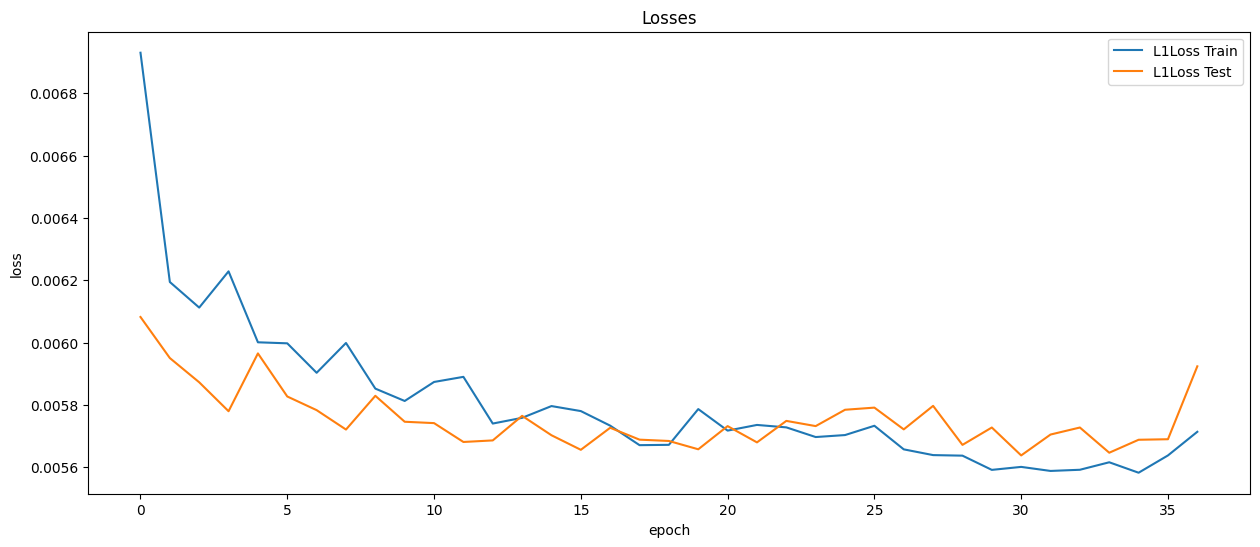

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses, '-')
plt.plot(test_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['L1Loss Train', 'L1Loss Test'])
plt.title('Losses');

Видим, что дальше учить нет смысла.

## Подготовка датасета с фоном

Из-за недостатка вычислительных ресурсов ранее мы учили на изображениях размерности 256*256. Этого недостаточно для требуемой для матирования детализации.

Теперь будем учить на изображениях оригинального разрешения, но в целях оптимизации уменьшим их количество в каждой папке до 5. Кроме того, наложим случайный фон под изображения каждого видео.

Кроме этого, далее будем использовать модель SAM2VideoPredictorTrain - переработанный для train predictor.

In [ ]:
# Путь к папкам fgr и pha
base_path = "/content/VideoMatte240K/VideoMatte240K_JPEG_SD/train"
folders = ["fgr", "pha", "train_test/fgr", "train_test/pha"]

max_images = 5

for folder in folders:
    folder_path = os.path.join(base_path, folder)

    # Сортируем папки по имени
    subfolders = sorted(os.listdir(folder_path))

    for i, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(folder_path, subfolder)

        if subfolder.startswith("0060_part") or subfolder.startswith("0115_part"):

            # Удаляем подпапку
            if os.path.isdir(subfolder_path):
                shutil.rmtree(subfolder_path)
                print(f"Deleted: {subfolder_path}")
        else:
          images = sorted(os.listdir(subfolder_path))
          for img_idx, img_name in enumerate(images):
              img_path = os.path.join(subfolder_path, img_name)
              if img_idx >= max_images:
                  os.remove(img_path)

print("Обработка завершена.")


Deleted: /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/fgr/0060_part1
Deleted: /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/fgr/0060_part2
Deleted: /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/pha/0060_part1
Deleted: /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/pha/0060_part2
Deleted: /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/train_test/fgr/0115_part1
Deleted: /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/train_test/fgr/0115_part2
Deleted: /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/train_test/pha/0115_part1
Deleted: /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/train_test/pha/0115_part2
Обработка завершена.


In [ ]:
import random

def add_backgrounds(base_path):
  # Пути к основным папкам
  fgr_path = os.path.join(base_path, "fgr")
  pha_path = os.path.join(base_path, "pha")
  backgrounds_path = "/content/drive/My Drive/Matting Project/Backgrounds"

  # Папка для сохранения композитных изображений
  output_path = os.path.join(base_path, "images")
  os.makedirs(output_path, exist_ok=True)

  # Получаем список папок (видео) в fgr и pha
  fgr_videos = sorted(os.listdir(fgr_path))
  pha_videos = sorted(os.listdir(pha_path))

  # Проверяем, что количество папок в fgr и pha совпадает
  assert len(fgr_videos) == len(pha_videos), "Количество видео-папок в fgr и pha должно совпадать!"

  # Функция для создания композитного изображения
  def create_composite(fgr, pha, background):
      """
      Смешивает передний план с альфа-каналом и фоновое изображение.
      """
      # Преобразуем изображения в массивы
      fgr = np.array(fgr) / 255.0  # Нормализуем от 0 до 1
      pha = np.array(pha) / 255.0  # Нормализуем от 0 до 1
      background = np.array(background) / 255.0  # Нормализуем от 0 до 1

      # Изменяем размер background до размера fgr/pha
      background = np.array(Image.fromarray((background * 255).astype(np.uint8)).resize((fgr.shape[1], fgr.shape[0]))) / 255.0

      # Композиция: alpha * foreground + (1 - alpha) * background
      composite = (pha[..., None] * fgr) + ((1 - pha[..., None]) * background)
      return (composite * 255).astype(np.uint8)  # Возвращаем в диапазон [0, 255]

  # Проходим по всем папкам (видео)
  for fgr_video, pha_video in zip(fgr_videos, pha_videos):
      # Путь к текущим папкам с кадрами
      fgr_video_path = os.path.join(fgr_path, fgr_video)
      pha_video_path = os.path.join(pha_path, pha_video)

      # Проверяем, что это действительно папки
      if not os.path.isdir(fgr_video_path) or not os.path.isdir(pha_video_path):
          continue

      # Список кадров в текущих папках
      fgr_frames = sorted(os.listdir(fgr_video_path))
      pha_frames = sorted(os.listdir(pha_video_path))

      # Проверяем, что количество кадров совпадает
      assert len(fgr_frames) == len(pha_frames), f"Количество кадров в {fgr_video} и {pha_video} должно совпадать!"

      # Выбираем один случайный фон для текущего видео
      background_file = random.choice(os.listdir(backgrounds_path))
      background_image = Image.open(os.path.join(backgrounds_path, background_file)).convert("RGB")

      # Папка для сохранения композитных изображений для текущего видео
      output_video_path = os.path.join(output_path, fgr_video)
      os.makedirs(output_video_path, exist_ok=True)

      # Создаём композиции для всех кадров текущего видео
      for fgr_frame, pha_frame in zip(fgr_frames, pha_frames):
          # Загружаем передний план и альфа-канал
          fgr_image = Image.open(os.path.join(fgr_video_path, fgr_frame)).convert("RGB")
          pha_image = Image.open(os.path.join(pha_video_path, pha_frame)).convert("L")  # Альфа-канал в градациях серого

          # Создаём композицию
          composite_image = create_composite(fgr_image, pha_image, background_image)

          # Сохраняем результат
          output_file = os.path.join(output_video_path, fgr_frame)
          Image.fromarray(composite_image).save(output_file)

  print(f"Готово! Композитные изображения сохранены в папку {output_path}.")


In [ ]:
add_backgrounds("/content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/train_test")

Готово! Композитные изображения сохранены в папку /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/train_test/images.


In [ ]:
add_backgrounds("/content/VideoMatte240K/VideoMatte240K_JPEG_SD/train")

Готово! Композитные изображения сохранены в папку /content/VideoMatte240K/VideoMatte240K_JPEG_SD/train/images.


In [ ]:
image_dir = os.path.join(train_dir, "images")
image_dir_test = os.path.join(test_dir, "images")

In [ ]:
video_ids = sorted(os.listdir(image_dir))
video_ids_test = sorted(os.listdir(image_dir_test))

## Подготовка к обучению

Загружаем SAM2VideoPredictorTrain с помощью кастомной функции build_sam2_video_predictor_matting

In [ ]:
from sam2.build_sam_matting import build_sam2_video_predictor_matting

checkpoint = "/content/drive/My Drive/Matting Project/checkpoints/latest_checkpoint.pth"
model_cfg = "sam2.1_hiera_l_predictor.yaml"
predictor = build_sam2_video_predictor_matting(model_cfg, checkpoint, train = True)

In [ ]:
lora_params = [param for name, param in predictor.named_parameters() if "lora_adapter" in name]

for param in predictor.parameters():
      param.requires_grad = False

for param in lora_params:
      param.requires_grad = True

Функция для выбора случайной точки маски из 50% центральных

In [ ]:
def get_random_central_point_with_value_one(pha_image):
    # Преобразуем изображение в массив numpy
    image_array = np.array(pha_image)

    # Находим индексы всех точек, где значение равно 255
    points = np.argwhere(image_array == 255)

    # Проверяем, есть ли такие точки
    if len(points) == 0:
        raise ValueError("В изображении нет точек со значением 255.")

    # Находим центр изображения
    center_y, center_x = image_array.shape[0] / 2, image_array.shape[1] / 2

    # Вычисляем расстояния от каждой точки до центра
    distances = np.sqrt((points[:, 0] - center_y) ** 2 + (points[:, 1] - center_x) ** 2)

    # Сортируем точки по расстоянию до центра
    sorted_indices = np.argsort(distances)
    central_points = points[sorted_indices]

    # Берем 20% самых центральных точек
    num_central_points = max(1, len(central_points) // 5)
    selected_points = central_points[:num_central_points]

    # Выбираем случайную точку из 50% центральных
    random_point = selected_points[np.random.choice(selected_points.shape[0])]

    # Меняем порядок координат с (y, x) на (x, y) и возвращаем в формате [[x, y]]
    return np.array([[random_point[1], random_point[0]]])

Функции для загрузки данных и обучения

In [ ]:
def prepareDate(video_id, test = False):
  if test:
    image_video_dir = os.path.join(image_dir_test, video_id)
    pha_video_dir = os.path.join(pha_dir_test, video_id)
  else:
    image_video_dir = os.path.join(image_dir, video_id)
    pha_video_dir = os.path.join(pha_dir, video_id)

  pha_frames = sorted(os.listdir(pha_video_dir))
  pha_path = os.path.join(pha_video_dir, pha_frames[0])
  pha_image = Image.open(pha_path).convert("L")
  input_point = get_random_central_point_with_value_one(pha_image)

  return image_video_dir, input_point, pha_video_dir

In [ ]:
def processVideo(video_id, predictor, test = False):
    image_video_dir, input_point, pha_video_dir = prepareDate(video_id, test)
    state =predictor.init_state(image_video_dir)

    # add new prompts and instantly get the output on the same frame
    frame_idx, object_ids, masks = predictor.add_new_points_or_box(inference_state=state,
    frame_idx=0,
    obj_id=1,
    points=input_point,
    labels=np.array([1]))

    # propagate the prompts to get masklets throughout the video
    video_masks = {}  # video_segments contains the per-frame segmentation results
    for frame_idx, object_ids, masks in predictor.propagate_in_video(state):
        video_masks[frame_idx] = {
        obj_id: masks[i]
        for i, obj_id in enumerate(object_ids)
    }

    pha_frames = sorted(os.listdir(pha_video_dir))

    return  video_masks, pha_frames, pha_video_dir

In [ ]:
def loss_matting_video_pred(predictions, pha_frames, pha_video_dir):
  loss = 0
  l1_loss = nn.L1Loss()
  for i in range(len(predictions)):
    pha_path = os.path.join(pha_video_dir, pha_frames[i])
    pha_image = Image.open(pha_path).convert("L")
    pha_image = (T.ToTensor()(pha_image)[0]).to(device)
    pred = torch.sigmoid(predictions[i][1][0])
    loss += l1_loss(pred, pha_image)
  loss /= (len(predictions))
  return loss

## Обучение

In [ ]:
predictor = predictor.to(device)

In [ ]:
num_epochs = 10
optimizer = AdamW(lora_params, lr=1e-5)
loss_fn = loss_matting_video_pred

In [ ]:
checkpoint_path_latest = "/content/drive/MyDrive/Matting Project/checkpoints/latest_checkpoint_video_pred.pth"
start_epoch = 0
losses = []
test_losses = []

if os.path.exists(checkpoint_path_latest):
    start_epoch, losses, test_losses = load_checkpoint(predictor, optimizer, checkpoint_path_latest)
    print(f"Resuming training from epoch {start_epoch + 1}")

for epoch in range(start_epoch, num_epochs):
    loss_per_epoch = []
    predictor.train()
    for video_id in video_ids:
        predictions, pha_frames, pha_video_dir = processVideo(video_id, predictor)

        # Вычисляем loss, оптимизируем и выполняем другие шаги обучения
        loss = loss_fn(predictions, pha_frames, pha_video_dir)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_per_epoch.append(loss.item())
        torch.cuda.empty_cache()
        gc.collect()

    predictor.eval()
    test_loss_per_epoch = []
    with torch.no_grad():
        for video_id in video_ids_test:
          predictions, pha_frames, pha_video_dir = processVideo(video_id, predictor, True)

          # Вычисляем loss
          loss = loss_fn(predictions, pha_frames, pha_video_dir)
          test_loss_per_epoch.append(loss.item())


    losses.append(np.mean(loss_per_epoch))
    test_losses.append(np.mean(test_loss_per_epoch))
    save_checkpoint(
         predictor, optimizer, epoch + 1, losses, test_losses, checkpoint_path_latest
    )
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses[-1]}, EvalLoss: {test_losses[-1]}")

<ipython-input-31-22a5ddb48a4d>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu")


Checkpoint loaded from /content/drive/MyDrive/Matting Project/checkpoints/latest_checkpoint_video_pred.pth, starting from epoch 11
Resuming training from epoch 11


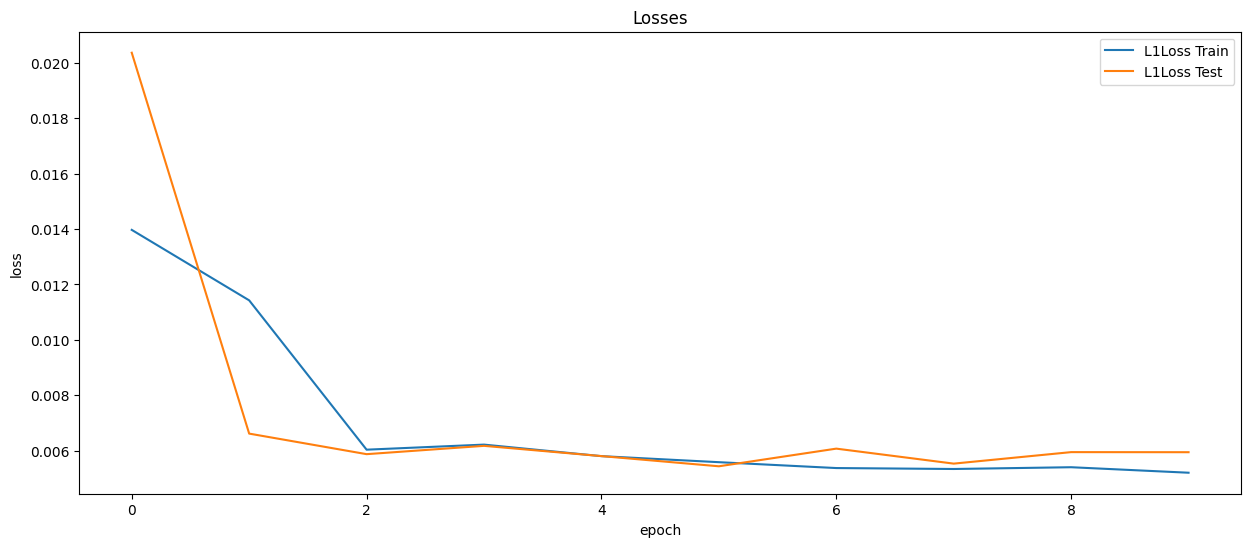

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses, '-')
plt.plot(test_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['L1Loss Train', 'L1Loss Test'])
plt.title('Losses');

## Датасет RefMatte_RW_100

Из-за того, что используемый ранее датасет VideoMatte240K содержит только один движущийся объект на каждом видео, дообученная модель имеет отрицательную сторону. Теперь они хуже справляется с трекингов нескольких движущихся объектов.

Частично решить эту проблему помогает обучение на изображенияъ RefMatte_RW_100, на которых представлено несколько масок. Однако в этом сокращенном датасете только 100 изображений. Полная версия же вестит очень много и не подходит для обучения нейросети с имеющимися ресурсами.

In [ ]:
import zipfile

# Путь к архиву
archive_path = '/content/drive/MyDrive/Matting Project/RefMatte_RW_100.zip'

# Папка, куда мы разархивируем данные
extract_path = '/content/RefMatte_RW_100'

# Разархивируем файл
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Архив разархивирован в {extract_path}")

Архив разархивирован в /content/RefMatte_RW_100


In [ ]:
# Пути к данным
image_dir = '/content/RefMatte_RW_100/RefMatte_RW_100/image'
mask_dir = '/content/RefMatte_RW_100/RefMatte_RW_100/mask'

# Получаем список изображений из директории image
image_files = os.listdir(image_dir)

for image_file in image_files:
    # Полный путь к изображению
    image_path = os.path.join(image_dir, image_file)

    # Название изображения без расширения
    image_name, _ = os.path.splitext(image_file)

    if (image_name == ".DS_Store"):
      continue

    # Создаем директорию для текущего изображения в image
    image_output_dir = os.path.join(image_dir, image_name)
    if not os.path.exists(image_output_dir):
        os.makedirs(image_output_dir)

    # Перемещаем изображение в соответствующую подпапку
    shutil.move(image_path, os.path.join(image_output_dir, image_file))

    # Теперь нужно найти все маски, соответствующие этому изображению
    # Маски имеют такой же префикс, как изображение, но могут иметь разные суффиксы
    matching_masks = [mask for mask in os.listdir(mask_dir) if mask.startswith(image_name)]

    for mask in matching_masks:
        mask_path = os.path.join(mask_dir, mask)

        # Создаем директорию для маски в mask
        mask_output_dir = os.path.join(mask_dir, image_name)
        if not os.path.exists(mask_output_dir):
            os.makedirs(mask_output_dir)

        # Перемещаем маску в соответствующую подпапку
        shutil.move(mask_path, os.path.join(mask_output_dir, mask))

image_files = os.listdir(image_dir)

print("Процесс завершён. Изображения и маски перемещены в соответствующие подпапки.")


Процесс завершён. Изображения и маски перемещены в соответствующие подпапки.


Переименовываем изображения и папки, так как наша нейросеть при обучении воспринимает только изображения с числовыми названиями.

In [ ]:
# Путь к корневой директории
root_path = "/content/RefMatte_RW_100/RefMatte_RW_100/image"
root_path2 = "/content/RefMatte_RW_100/RefMatte_RW_100/mask"

# Получаем список папок и сортируем их для последовательности
folders = sorted(os.listdir(root_path))
for idx, folder_name in enumerate(folders, start=1):
    folder_path = os.path.join(root_path, folder_name)
    folder_path2 = os.path.join(root_path2, folder_name)

    # Проверяем, что это папка
    if os.path.isdir(folder_path):
        # Новое имя для папки (числовое)
        new_folder_name = str(idx)
        new_folder_path = os.path.join(root_path, new_folder_name)
        new_folder_path2 = os.path.join(root_path2, new_folder_name)

        # Переименовываем папку
        os.rename(folder_path, new_folder_path)
        os.rename(folder_path2, new_folder_path2)

        # Получаем список файлов в папке (их там должен быть один)
        files = os.listdir(new_folder_path)
        if len(files) == 1:
            old_file_name = files[0]
            old_file_path = os.path.join(new_folder_path, old_file_name)

            # Новое имя файла (такое же, как имя папки с добавлением расширения)
            file_extension = os.path.splitext(old_file_name)[1]
            new_file_name = f"{new_folder_name}{file_extension}"
            new_file_path = os.path.join(new_folder_path, new_file_name)

            # Переименовываем файл
            os.rename(old_file_path, new_file_path)

## Дообучение

Добавяляем функции для удобства работы с новыми данными и дообучаем сеть

In [ ]:
def prepareDateRefMat(image_id):
  image_dir_current = os.path.join(image_dir, image_id)
  pha_dir_current = os.path.join(mask_dir, image_id)
  input_points = []

  pha_frames = sorted(os.listdir(pha_dir_current))
  for i in range(len(pha_frames)):
    pha_path = os.path.join(pha_dir_current, pha_frames[i])
    pha_image = Image.open(pha_path).convert("L")
    input_point = get_random_central_point_with_value_one(pha_image)
    input_points.append(input_point)

  return image_dir_current, input_points, pha_dir_current

In [ ]:
def loss_matting_video_pred_ref_mat(predictions, pha_dir):
  loss = 0
  l1_loss = nn.L1Loss()
  pha_frames = sorted(os.listdir(pha_dir))
  for i in range(len(pha_frames)):
    pha_path = os.path.join(pha_dir, pha_frames[i])
    pha_image = Image.open(pha_path).convert("L")
    pha_image = (T.ToTensor()(pha_image)[0]).to(device)
    pred = torch.sigmoid(predictions[i+1][0])
    loss += l1_loss(pred, pha_image)
  loss /= (len(pha_frames))
  return loss

In [ ]:
image_dir = '/content/RefMatte_RW_100/RefMatte_RW_100/image'
mask_dir = '/content/RefMatte_RW_100/RefMatte_RW_100/mask'
image_files = os.listdir(image_dir)
total_files = len(image_files)

split_index = int(total_files * 0.8)

image_ids = sorted(image_files[:split_index])  # Первые 80%
image_ids_test = sorted(image_files[split_index:])  # Оставшиеся 20%

In [ ]:
num_epochs = 10
optimizer = AdamW(lora_params, lr=1e-5)
loss_fn = loss_matting_video_pred_ref_mat

In [ ]:
checkpoint_path_latest = "/content/drive/MyDrive/Matting Project/checkpoints/latest_checkpoint_video_pred_matref.pth"
start_epoch = 0
losses = []
test_losses = []

if os.path.exists(checkpoint_path_latest):
    start_epoch, losses, test_losses = load_checkpoint(predictor, optimizer, checkpoint_path_latest)
    print(f"Resuming training from epoch {start_epoch + 1}")

for epoch in range(start_epoch, num_epochs):
    loss_per_epoch = []
    predictor.train()
    for image_id in image_ids:
        if image_id == ".DS_Store":
          continue
        image_dir_cur, input_points, pha_dir_cur = prepareDateRefMat(image_id)
        state =predictor.init_state(video_path =image_dir_cur)
        i = 1

        for input_point in input_points:
          # add new prompts and instantly get the output on the same frame
          frame_idx, object_ids, masks = predictor.add_new_points_or_box(inference_state=state,
          frame_idx=0,
          obj_id=i,
          points=input_point,
          labels=np.array([1]))
          i = i+1

        video_masks = {
          obj_id: masks[i]
          for i, obj_id in enumerate(object_ids)
        }

        # Вычисляем loss, оптимизируем и выполняем другие шаги обучения
        loss = loss_fn(video_masks, pha_dir_cur)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_per_epoch.append(loss.item())
        torch.cuda.empty_cache()
        gc.collect()

    predictor.eval()
    test_loss_per_epoch = []
    with torch.no_grad():
        for image_id in image_ids_test:
          image_dir_cur, input_points, pha_dir_cur = prepareDateRefMat(image_id)
          state =predictor.init_state(image_dir_cur)
          i = 1

          for input_point in input_points:
            # add new prompts and instantly get the output on the same frame
            frame_idx, object_ids, masks = predictor.add_new_points_or_box(inference_state=state,
            frame_idx=0,
            obj_id=i,
            points=input_point,
            labels=np.array([1]))
            i = i+1

          video_masks = {
            obj_id: masks[i]
            for i, obj_id in enumerate(object_ids)
          }

          # Вычисляем loss
          loss = loss_fn(video_masks, pha_dir_cur)
          test_loss_per_epoch.append(loss.item())


    losses.append(np.mean(loss_per_epoch))
    test_losses.append(np.mean(test_loss_per_epoch))
    save_checkpoint(
         predictor, optimizer, epoch + 1, losses, test_losses, checkpoint_path_latest
    )
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses[-1]}, EvalLoss: {test_losses[-1]}")

<ipython-input-31-22a5ddb48a4d>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cpu")


Checkpoint loaded from /content/drive/MyDrive/Matting Project/checkpoints/latest_checkpoint_video_pred_matref.pth, starting from epoch 11
Resuming training from epoch 11


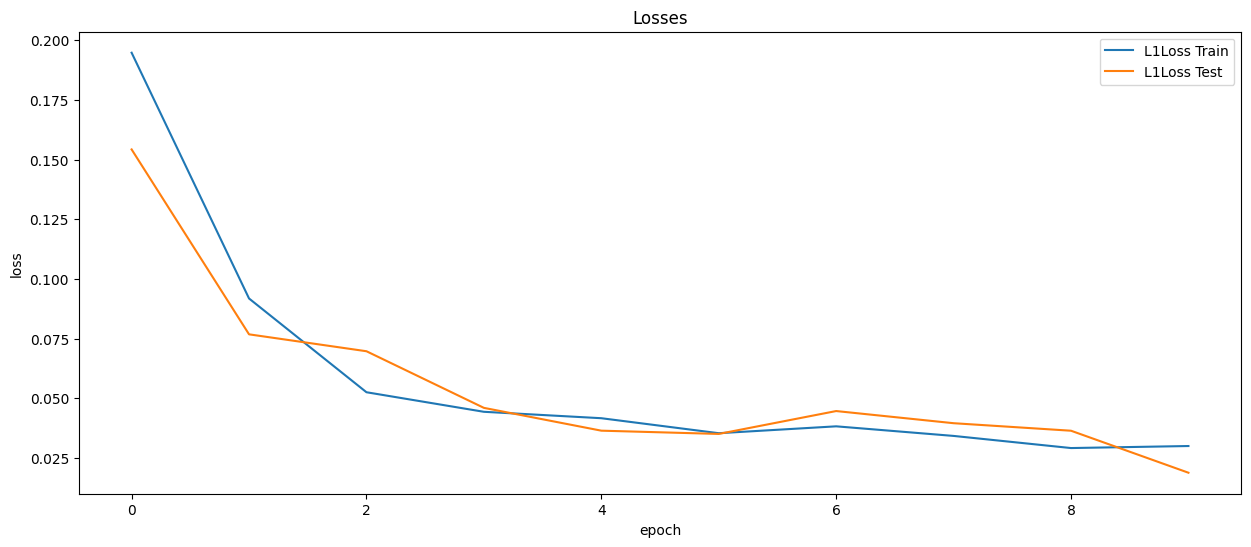

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses, '-')
plt.plot(test_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['L1Loss Train', 'L1Loss Test'])
plt.title('Losses');

Сохраняем чекпойнты по финальному адресу

In [ ]:
current_checkpoint_path = "/content/drive/MyDrive/Matting Project/checkpoints/latest_checkpoint_video_pred_matref.pth"
output_checkpoint_path = "/content/drive/MyDrive/Matting Project/checkpoints/sam2.1_hiera_large_matting.pt"

checkpoint = torch.load(current_checkpoint_path, map_location="cpu")

torch.save(checkpoint, output_checkpoint_path)

print(f"Checkpoint успешно сохранены в {output_checkpoint_path}")

<ipython-input-78-54152cd0e469>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(current_checkpoint_path, map_location="cpu")


Checkpoint успешно сохранены в /content/drive/MyDrive/Matting Project/checkpoints/sam2.1_hiera_large_matting.pt
